<a href="https://colab.research.google.com/github/GaioAugusto/APS360-Labs/blob/main/Lab2_Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1Epnvt2AQug1Pr5bCgCkWoWVh8Mge7cfz/view?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170M/170M [00:03<00:00, 43.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

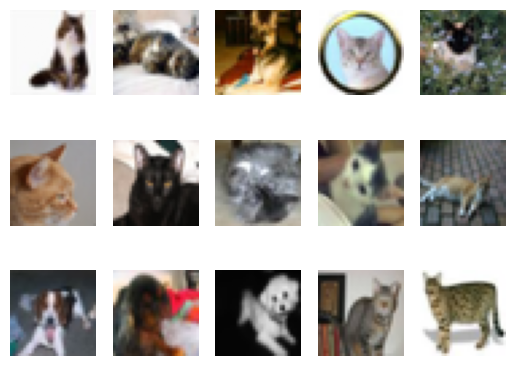

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [ ]:
train_count = 0
for images, labels in train_loader:
    train_count += images.size(0)
print(f"Training set size: {train_count}")

val_count = 0
for images, labels in val_loader:
    val_count += images.size(0)
print(f"Validation set size: {val_count}")

test_count = 0
for images, labels in test_loader:
    test_count += images.size(0)
print(f"Test set size: {test_count}")

Training set size: 8000
Validation set size: 2000
Test set size: 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

We need a validation set so we can tune our hyperparameters. If we judge the performance using the training set only we will not be considering overfitting and the fact that the model may be memorizing the seen data.

In [ ]:
# We need a validation set so we can tune our hyperparameters. If we judge the performance using the training
# set only we will not be considering overfitting and the fact that the model may be memorizing the seen data.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
for param in small_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


In [ ]:
conv_weights = 5 * 3 * 3 * 3
conv_bias = 5
fc_weights = 245
fc_bias = 1

num_of_parameters_small = conv_weights + conv_bias + fc_weights + fc_bias
print("The number of parameters in the small network is:", num_of_parameters_small)

The number of parameters in the small network is: 386


In [ ]:
for param in large_net.parameters():
  print(param.shape)

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


In [ ]:
conv_weights_large = 5 * 3 * 5 * 5
conv_bias_large = 5
conv2_weights_large = 10 * 5 * 5 * 5
conv2_bias_large = 10
fc_weights_large = 32 * 250
fc_bias_large = 32
fc2_weights_large = 32
fc2_bias_large = 1

num_of_parameters_large = conv_weights_large + conv_bias_large + conv2_weights_large + conv2_bias_large + fc_weights_large + fc_bias_large + fc2_weights_large + fc2_bias_large
print("The number of parameters in the large network is:", num_of_parameters_large)


The number of parameters in the large network is: 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

In [ ]:
# batch size is 64
# learning rate is 0.01
# number of epochs is 30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
# hold learned parameters at the end of each epoch
# model_small_bs64_lr0.01_epoch0
#	model_small_bs64_lr0.01_epoch1
#	model_small_bs64_lr0.01_epoch2
#	model_small_bs64_lr0.01_epoch3
#	model_small_bs64_lr0.01_epoch4

# hold training and validation error/loss
# model_small_bs64_lr0.01_epoch4_train_err.csv
# model_small_bs64_lr0.01_epoch4_train_loss.csv
# model_small_bs64_lr0.01_epoch4_val_err.csv
# model_small_bs64_lr0.01_epoch4_val_loss.csv

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4255, Train loss: 0.67403480052948 |Validation err: 0.3715, Validation loss: 0.6564916744828224
Epoch 2: Train err: 0.370375, Train loss: 0.6466458358764648 |Validation err: 0.375, Validation loss: 0.659381803125143
Epoch 3: Train err: 0.352625, Train loss: 0.6331322174072266 |Validation err: 0.348, Validation loss: 0.6294368766248226
Epoch 4: Train err: 0.33675, Train loss: 0.6188613357543945 |Validation err: 0.359, Validation loss: 0.6329382807016373
Epoch 5: Train err: 0.3315, Train loss: 0.6095153512954712 |Validation err: 0.331, Validation loss: 0.6217068675905466
Epoch 6: Train err: 0.314, Train loss: 0.5982177970409394 |Validation err: 0.33, Validation loss: 0.6156173702329397
Epoch 7: Train err: 0.315875, Train loss: 0.5913721015453338 |Validation err: 0.325, Validation loss: 0.6069718990474939
Epoch 8: Train err: 0.304875, Train loss: 0.5829969809055329 |Validation err: 0.32, Vali

In [ ]:
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.46875, Train loss: 0.6925259137153625 |Validation err: 0.457, Validation loss: 0.690463088452816
Epoch 2: Train err: 0.449375, Train loss: 0.6871864986419678 |Validation err: 0.4225, Validation loss: 0.6801956929266453
Epoch 3: Train err: 0.4165, Train loss: 0.6754467692375183 |Validation err: 0.3895, Validation loss: 0.6601769030094147
Epoch 4: Train err: 0.38075, Train loss: 0.6550140223503113 |Validation err: 0.395, Validation loss: 0.6469433009624481
Epoch 5: Train err: 0.36125, Train loss: 0.6345323915481568 |Validation err: 0.3475, Validation loss: 0.6242898553609848
Epoch 6: Train err: 0.3435, Train loss: 0.6166091060638428 |Validation err: 0.3455, Validation loss: 0.6239369921386242
Epoch 7: Train err: 0.32725, Train loss: 0.6002647573947907 |Validation err: 0.32, Validation loss: 0.5985061079263687
Epoch 8: Train err: 0.31875, Train loss: 0.5850588319301605 |Validation err: 0.328,

The larger network took more time to train, this happened because there are more layers and more parameters, meaning more computations, to be trained.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

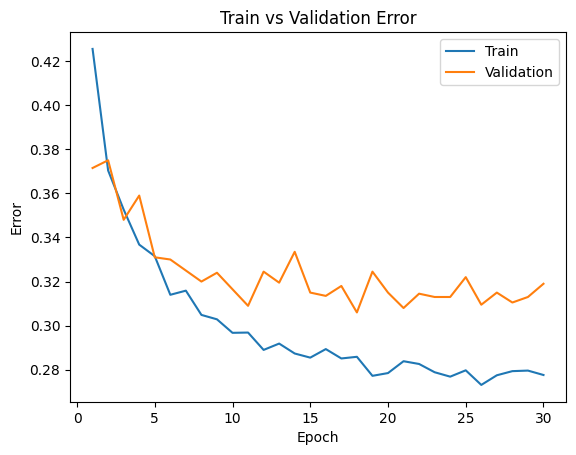

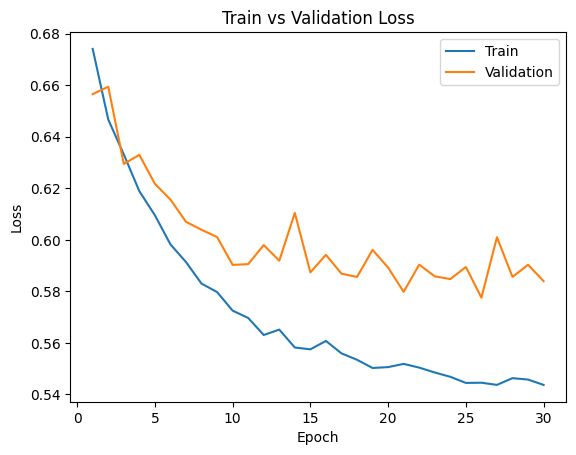

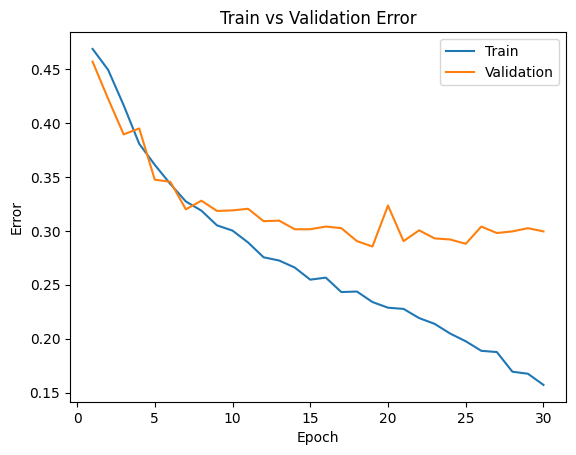

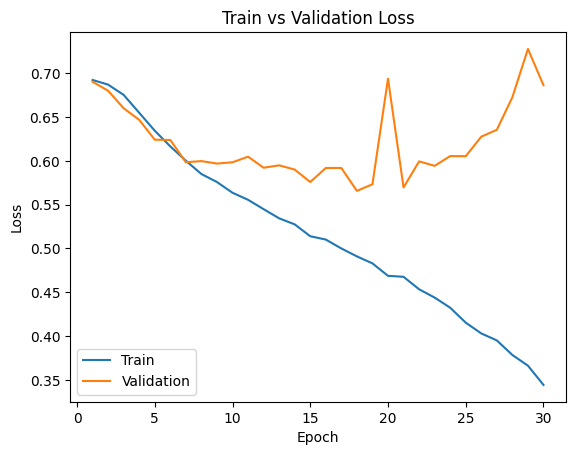

In [ ]:
model_path_small = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_small)

model_path_large = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [ ]:
# Small net (first 2 graphs)
  # there is not a large difference between training and validation performances.

# Large net (last 2 graphs)
  # training error and loss drop much lower than for the smaller network, but this does not happen in validation, which indicates overfitting

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Took longer to train. The effect of lowering the learning rate was that the decrease in training and validation loss/error was SLOWER due to more gradually weight updates

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360004425049 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589716911316 |Validation err: 0.4305, Validation loss: 0.6916493363678455
Epoch 3: Train err: 0.43575, Train loss: 0.6916067404747009 |Validation err: 0.4285, Validation loss: 0.6908544525504112
Epoch 4: Train err: 0.430125, Train loss: 0.6908613877296448 |Validation err: 0.424, Validation loss: 0.68965969607234
Epoch 5: Train err: 0.434125, Train loss: 0.6899198365211486 |Validation err: 0.4195, Validation loss: 0.688694279640913
Epoch 6: Train err: 0.435875, Train loss: 0.6887419748306275 |Validation err: 0.4195, Validation loss: 0.6867837496101856
Epoch 7: Train err: 0.436625, Train loss: 0.6873781814575195 |Validation err: 0.4185, Validation loss: 0.6851996649056673
Epoch 8: Train err: 0.43725, Train loss: 0.6859267811775207 |Validation err: 

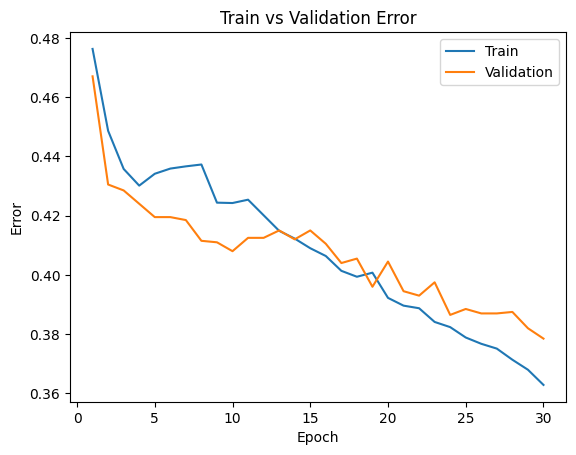

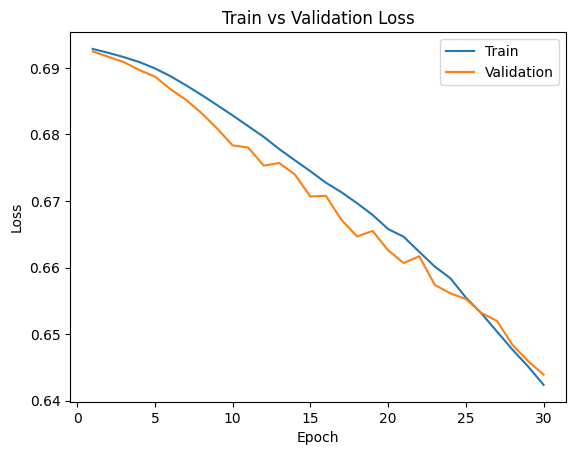

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=30)

model_path_large = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_large)

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Took a litte bit longer than what it took with the initial default parameters, but roughly the same. There was a huge gap between the training and validation error after a certain point, indicating that the model did not perform well with a higher learning rate. The validation accuracy got worse with more epochs

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.6743808445930481 |Validation err: 0.3565, Validation loss: 0.6350402887910604
Epoch 2: Train err: 0.36925, Train loss: 0.6415545463562011 |Validation err: 0.3515, Validation loss: 0.6243696268647909
Epoch 3: Train err: 0.366, Train loss: 0.6304733338356018 |Validation err: 0.3475, Validation loss: 0.6173483617603779
Epoch 4: Train err: 0.35775, Train loss: 0.6251179370880127 |Validation err: 0.3345, Validation loss: 0.620793430134654
Epoch 5: Train err: 0.33675, Train loss: 0.6045795600414277 |Validation err: 0.329, Validation loss: 0.5937281344085932
Epoch 6: Train err: 0.31775, Train loss: 0.5828781847953797 |Validation err: 0.3275, Validation loss: 0.6041664052754641
Epoch 7: Train err: 0.3195, Train loss: 0.5794640259742737 |Validation err: 0.334, Validation loss: 0.6052154619246721
Epoch 8: Train err: 0.311875, Train loss: 0.5757701637744903 |Validation err: 0.318,

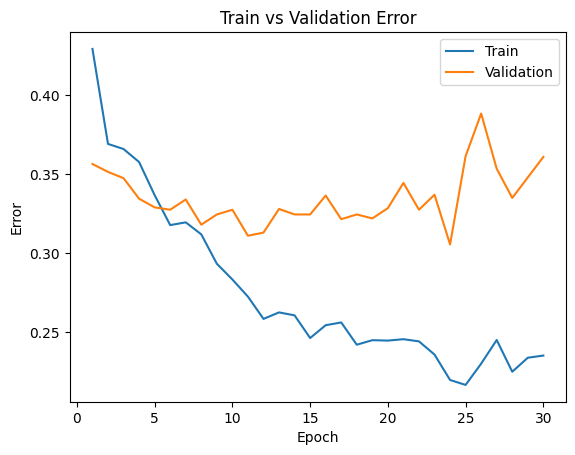

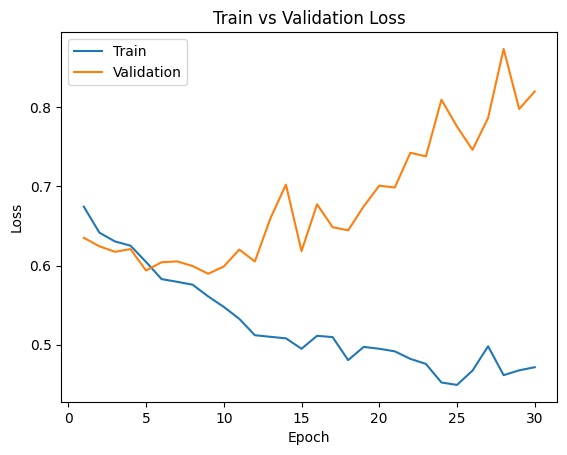

In [ ]:
large_net = LargeNet()

train_net(large_net, batch_size=64, learning_rate=0.1, num_epochs=30)

model_path_large = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path_large)

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Took less time to train. It made the model perform very similarly and sometimes even better in validation than in training.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.692410409450531 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909130215644836
Epoch 4: Train err: 0.433625, Train loss: 0.6908449903130531 |Validation err: 0.424, Validation loss: 0.6897870302200317
Epoch 5: Train err: 0.434, Train loss: 0.6896935515105724 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883532106876373 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871826350689 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770620465279 |Validation err: 0.411, Val

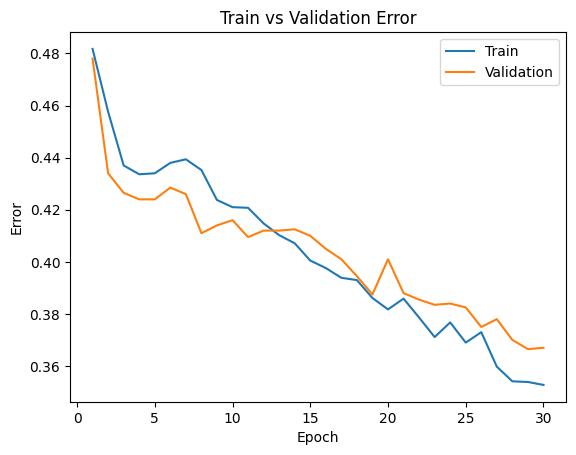

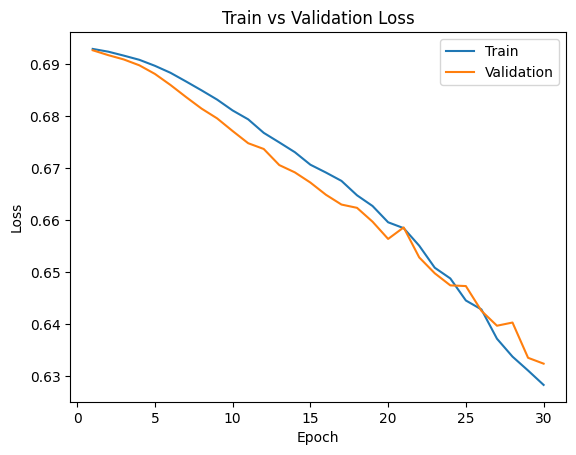

In [ ]:
large_net = LargeNet()

train_net(large_net, batch_size=512, learning_rate=0.01, num_epochs=30)

model_path_large = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Took much longer to train. Also the performance of validation got way worse than training with more epochs

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.432625, Train loss: 0.6775506126880646 |Validation err: 0.378, Validation loss: 0.6512571973800659
Epoch 2: Train err: 0.366375, Train loss: 0.6387728816270828 |Validation err: 0.337, Validation loss: 0.612742235660553
Epoch 3: Train err: 0.339375, Train loss: 0.6119522891640663 |Validation err: 0.345, Validation loss: 0.6396356213092804
Epoch 4: Train err: 0.312125, Train loss: 0.5861616842746734 |Validation err: 0.3375, Validation loss: 0.6223122742176056
Epoch 5: Train err: 0.309125, Train loss: 0.5655454085469246 |Validation err: 0.303, Validation loss: 0.5682719912528992
Epoch 6: Train err: 0.283875, Train loss: 0.546434996843338 |Validation err: 0.3125, Validation loss: 0.581913836479187
Epoch 7: Train err: 0.275625, Train loss: 0.5315411986708641 |Validation err: 0.3185, Validation loss: 0.5755203785896301
Epoch 8: Train err: 0.253625, Train loss: 0.5110043309926987 |Validation err:

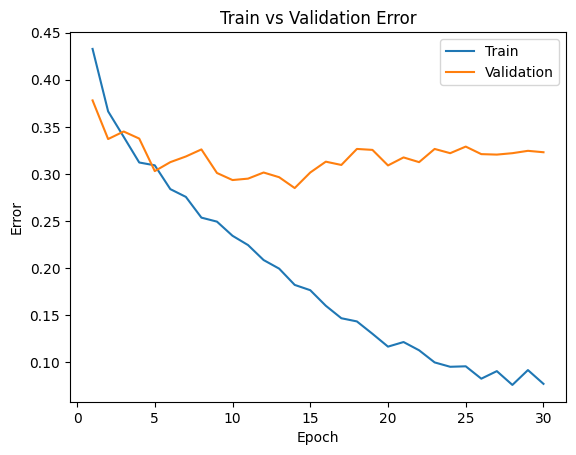

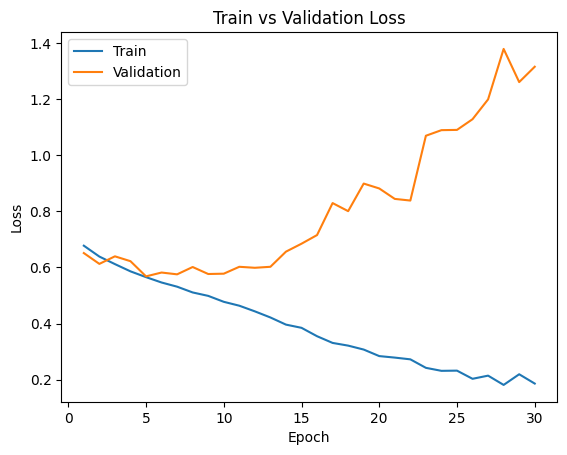

In [ ]:
large_net = LargeNet()

train_net(large_net, batch_size=16, learning_rate=0.01, num_epochs=30)

model_path_large = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [ ]:
# I decided to decrease the learning rate once again to 0.001 because I managed to achieve stable results with it.
# However, since the model did not converge to the optimal value with 30 epochs, I decided to also decrease the batch size
# to 16, in an attempt to make the model converge to the minimum error/loss value faster even with a lower learning rate

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.454875, Train loss: 0.6919687832593918 |Validation err: 0.4335, Validation loss: 0.6896940717697143
Epoch 2: Train err: 0.441875, Train loss: 0.688197230219841 |Validation err: 0.4155, Validation loss: 0.6840263233184815
Epoch 3: Train err: 0.42525, Train loss: 0.6826247880458832 |Validation err: 0.4065, Validation loss: 0.67605153799057
Epoch 4: Train err: 0.41325, Train loss: 0.676577262043953 |Validation err: 0.411, Validation loss: 0.6703953032493591
Epoch 5: Train err: 0.40275, Train loss: 0.6707149134874344 |Validation err: 0.4045, Validation loss: 0.66364732837677
Epoch 6: Train err: 0.388125, Train loss: 0.6635025647878647 |Validation err: 0.3895, Validation loss: 0.6577807388305664
Epoch 7: Train err: 0.383125, Train loss: 0.6566041198968887 |Validation err: 0.388, Validation loss: 0.6489925136566163
Epoch 8: Train err: 0.373625, Train loss: 0.6456227536797523 |Validation err: 0.3

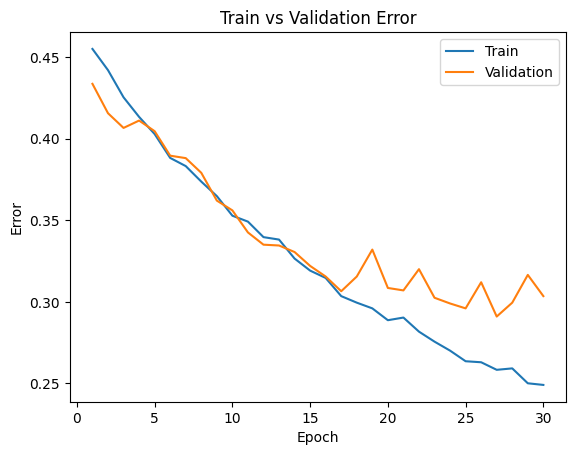

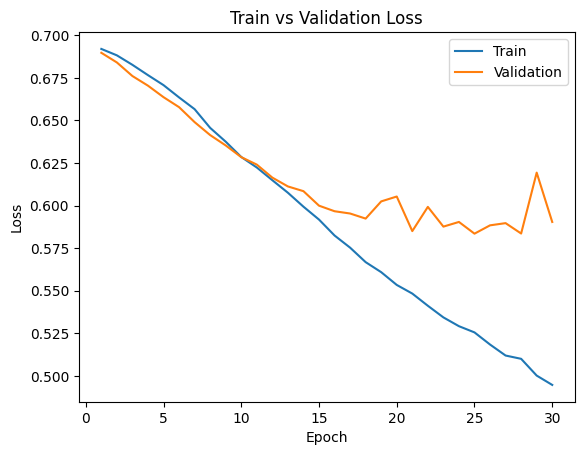

In [ ]:
large_net = LargeNet()

train_net(large_net, batch_size=16, learning_rate=0.001, num_epochs=30)

model_path_large = get_model_name("large", batch_size=16, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_large)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

In [ ]:
# The previous set of hyperparameters performed very well until epoch 25, when the validation error started to increase again
# This indicates overfitting. That is why I decided to simply stop earlier to try to get the best result.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.454875, Train loss: 0.6919687832593918 |Validation err: 0.4335, Validation loss: 0.6896940717697143
Epoch 2: Train err: 0.441875, Train loss: 0.688197230219841 |Validation err: 0.4155, Validation loss: 0.6840263233184815
Epoch 3: Train err: 0.42525, Train loss: 0.6826247880458832 |Validation err: 0.4065, Validation loss: 0.67605153799057
Epoch 4: Train err: 0.41325, Train loss: 0.676577262043953 |Validation err: 0.411, Validation loss: 0.6703953032493591
Epoch 5: Train err: 0.40275, Train loss: 0.6707149134874344 |Validation err: 0.4045, Validation loss: 0.66364732837677
Epoch 6: Train err: 0.388125, Train loss: 0.6635025647878647 |Validation err: 0.3895, Validation loss: 0.6577807388305664
Epoch 7: Train err: 0.383125, Train loss: 0.6566041198968887 |Validation err: 0.388, Validation loss: 0.6489925136566163
Epoch 8: Train err: 0.373625, Train loss: 0.6456227536797523 |Validation err: 0.3

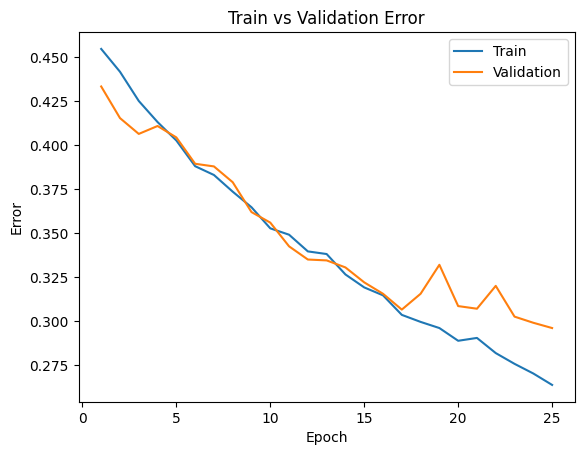

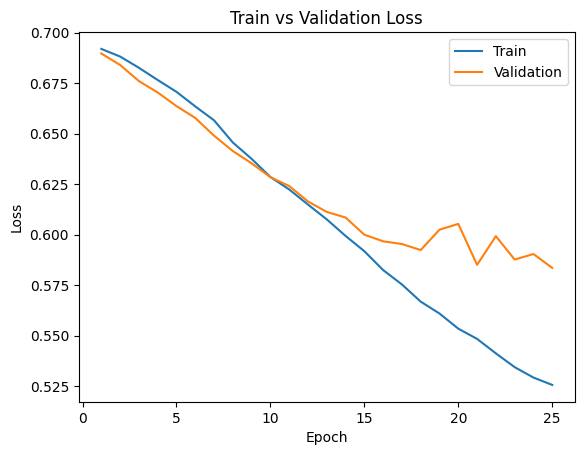

In [ ]:
large_net = LargeNet()

train_net(large_net, batch_size=16, learning_rate=0.001, num_epochs=25)

model_path_large = get_model_name("large", batch_size=16, learning_rate=0.001, epoch=24)
plot_training_curve(model_path_large)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=16, learning_rate=0.001, epoch=25)
state = torch.load(model_path)
net.load_state_dict(state)

<ipython-input-38-17c6c82b9dbb>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [ ]:
# I decided to decrease the batch size and the learning rate to get faster yet stable updates. I also
# decreased the number of epochs because with 30 iterations the model started to overfit

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=16)

loss_func = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(net, test_loader, loss_func)

print(f"Error = {test_err:.4f}")
print(f"Loss = {test_loss:.4f}")


Files already downloaded and verified
Files already downloaded and verified
Error = 0.2885
Loss = 0.5603


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
# The testing error was slightly lower than the validation error. However, we would expect
# the test error to be higher because the test set was not used and is unseen
# there could be a little bit of overfitting on the validation set

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [ ]:
# if we use the test data before we will be training with the test data so there will be no unseen data available
# making it hard to evaluate the true performance
# it is important to use testing data as little as possible to ensure that the final metric is a
# fair indicator of real-world performance

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.